In [5]:
using AutoEncoderToolkit
using AutoEncoderToolkit.VAEs
using Clustering                
using Combinatorics
using CUDA
using CSV
using DataFrames
using DelimitedFiles
using Distributions
using Distances
using FileIO
using Flux
using GaussianMixtures         
using Glob
using LinearAlgebra
using MAT                      
using Measures
using MultivariateStats         
using NIfTI
using Plots
using Printf
using Random
using RegressionDynamicCausalModeling
using Statistics
using StatsBase                
using TSne
using MultivariateStats: PCA, fit, transform

include("../timeseries_and_connectivity/utils.jl")
include("utils_clustering.jl")

const FUNC_DIR = "../data/FunImgARCFW_n88"
const RESULTS_DIR = "../connectivity_n88"
const ATLAS_DIR = "../data"
const FUNC_FILENAME = "wFiltered_4DVolume.nii"
const ATLAS_FILENAME = "BN_Atlas_246_3mm.nii"
const BNA_MATRIX_FILENAME = "../data/BNA_matrix_binary_246x246.csv"
const SUBDIAGNOSIS_CSV_FILENAME = "../data/sub_diagnosis_n88.csv"



"../data/sub_diagnosis_n88.csv"

Reprodusing the same steps as discribed in dim_reducation_and_clustering.ipynb

In [ ]:
# === Load and Prepare Connectivity Matrices ===

# 1. Load rDCM and functional connectivity data for all subjects from results directory
connectivity_data = load_connectivity_data(RESULTS_DIR; load_rdcm=true, load_functional=true)

# 2. Flatten each subject's connectivity matrices into vectors
#    - With mask: only values where the structural matrix (BNA) is 1
#    - Without mask: full flattened matrices
masked_connectivity_vectors = mask_and_flatten_connectivity_data(connectivity_data, BNA_MATRIX_FILENAME; mask=true)
connectivity_vectors = mask_and_flatten_connectivity_data(connectivity_data, BNA_MATRIX_FILENAME; mask=false)

# 3. Get the ordered list of subject IDs (used to align matrix rows with subject metadata)
subjectIDs = extract_allSubjectIDs(RESULTS_DIR)

# 4. Convert subject-wise vectors into subject × feature matrices
#    Each row = one subject; each column = one masked or full connectivity value
masked_connectivity_matrix = get_connectivity_matrix(masked_connectivity_vectors, subjectIDs)
connectivity_matrix = get_connectivity_matrix(connectivity_vectors, subjectIDs)

# 5. Extract only functional connectivity ("fc_mat") from full and masked data
matrix_fc = get_connectivity_matrix(connectivity_vectors, subjectIDs, "fc_mat")
matrix_masked_fc = get_connectivity_matrix(masked_connectivity_vectors, subjectIDs, "fc_mat")


# Load CSV and skip the first row
data_table = CSV.read(SUBDIAGNOSIS_CSV_FILENAME, DataFrame; delim=',', skipto=2)
# Extract the 'group_1till5' column and convert to Int
group_col = data_table[!, Symbol("group [1-4, 4=NC, 3=PTSD+TBI, 2=PTSD, 1=TBI]")]
group_array = convert(Vector{Int}, group_col)  # convert to a plain array of Ints

train VAE

In [ ]:
# Dictionary to store all trained models and their metrics
vae_results = Dict()
n_epochs = 30
dims_list = [2, 10, 20, 50, 100]
data_sources= Dict("RDCM" => connectivity_matrix, "FC" => matrix_masked_fc)
# Loop over datasets and latent dimensions
for (data_name, matrix) in data_sources
    println("Training on dataset: $data_name")

    dataset_results = Dict()
    matrix_f32 = Float32.((matrix))

    for dim in dims_list
        println("  Latent Dim: $dim")

        # Train the model
        vae_model, metrics = train_vae_model(matrix_f32, dim, n_epochs)

        # Save model and metrics
        dataset_results[string(dim)] = (
            model = vae_model,
            metrics = metrics,
        )
    end

    vae_results[data_name] = dataset_results
end


Run experiments with different  dimensionality reducation methods, dimensionalities and clustering techniques 


In [ ]:
dims_list_dimExp = [2, 10, 20, 50, 100]
data_sources_dimExp = Dict("RDCM" => connectivity_matrix, "FC" => matrix_masked_fc)
methods_dimExp = ["PCA", "tSNE", "VAE"]
repeats_dimExp = 2
clustering_methods_dimExp = ["kmeans", "fuzzy","hierarchical"]
select_counts = [20, 20, 0, 20] 

results_dimExp, grouped_dimExp, all_results_dimExp = evaluate_dimensionality_reduction(
    dims_list_dimExp,
    data_sources_dimExp,
    methods_dimExp,
    repeats_dimExp,
    clustering_methods_dimExp,
    vae_results,
    group_array,
    select_counts
)

display(results_dimExp)  # Summary DataFrame

#Run experiments without dimensionality reducation 
dims_list_noLatent = [0]
data_sources_noLatent = Dict("RDCM" => connectivity_matrix, "FC" => matrix_masked_fc)
methods_noLatent = ["NoLatent"]
repeats_noLatent = 50
clustering_methods_noLatent = ["kmeans", "fuzzy","hierarchical"]
select_counts = [20, 20, 0, 20]   

results_noLatent, grouped_noLatent, all_result_noLatent = evaluate_dimensionality_reduction(
    dims_list_noLatent,
    data_sources_noLatent,
    methods_noLatent,
    repeats_noLatent,
    clustering_methods_noLatent,
    vae_results,
    group_array,
    select_counts
)

display(results_noLatent) 

Simulate Random Guess Accuracy

In [ ]:
# Random clustering accuracy

using Random, Statistics, Plots

# Simulated inputs
μ_result = rand(88, 20)

# Select subset
selected_data, true_labels, _ = select_subjects_by_group(μ_result, group_array, [20, 20, 0, 20])

# Random clustering accuracy
N = 100  # number of trials
acc_list = Float64[]

for i in 1:N
    random_labels = rand([1, 2, 3], length(true_labels))
    acc = accuracy_score(true_labels, random_labels)
    push!(acc_list, acc)
end

mean_acc_random = mean(acc_list)
std_acc_random = std(acc_list)

Different clustering techniques plot 

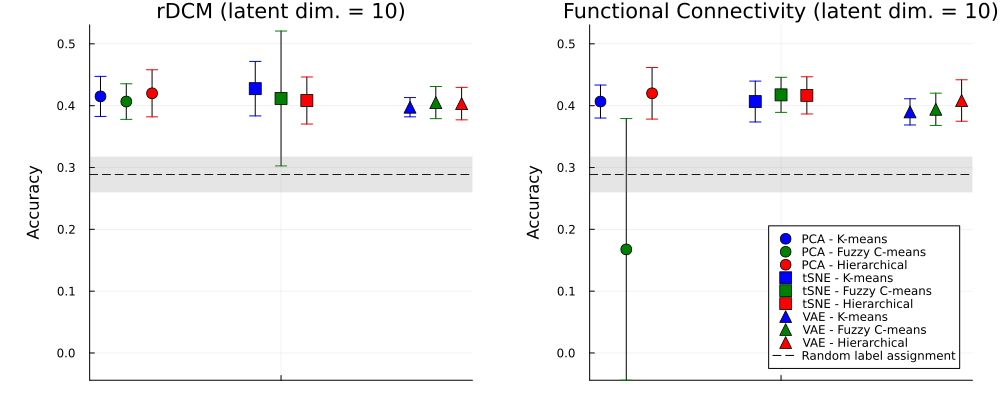

"g:\\Lyubov\\TNM_project\\10dim.pdf"

In [ ]:
using Plots
using DataFrames
using StatsPlots

# Setup
dims_list = [10]
x_positions = Dict(d => i for (i, d) in enumerate(dims_list))

# Offsets
method_offset = Dict("PCA" => -0.06, "tSNE" => 0.0, "VAE" => 0.06)
clustering_offset = Dict("kmeans" => -0.01, "fuzzy" => 0, "hierarchical" => 0.01)

# Marker styles
method_shape = Dict("PCA" => :circle, "tSNE" => :square, "VAE" => :utriangle)
clustering_color = Dict("kmeans" => :blue, "fuzzy" => :green, "hierarchical" => :red)

# Data and clustering methods to use
clustering_methods, datasets, dims = (["kmeans", "fuzzy", "hierarchical"], ["RDCM", "FC"], [10])

# First pass to find y-limits
acc_values = Float64[]
for dataset in datasets
    filtered = filter(row -> row.Data == dataset && row.Clustering in clustering_methods &&  row.Dims in dims, results_dimExp)
    append!(acc_values, filtered.MeanAcc .+ filtered.StdAcc)
    append!(acc_values, filtered.MeanAcc .- filtered.StdAcc)
end
ymin, ymax = extrema(acc_values) 
ymax = ymax + 0.01

# Create subplot layout - no legend by default
plt = plot(layout = (1, 2), size = (1000, 400), legend = false, left_margin = 10mm, right_margin = 5mm)

for (i, dataset) in enumerate(datasets)
    filtered = filter(row -> row.Data == dataset && row.Clustering in clustering_methods &&  row.Dims in dims,  results_dimExp)
    grouped = groupby(filtered, [:Method, :Clustering, ])

    for g in grouped
        method = g.Method[1]
        clustering = g.Clustering[1]

        # Replace this line:
        # label = "$method - $clustering"

        # With this conditional version:
        clustering_name = if clustering == "fuzzy"
            "Fuzzy C-means"
        elseif clustering == "kmeans"
            "K-means"
        elseif clustering == "hierarchical"
            "Hierarchical"
        else
            clustering  # fallback for any other cases
        end
        label = "$method - $clustering_name"

        x_base = [x_positions[d] for d in g.Dims]
        x_vals = [
            x + get(method_offset, method, 0.0) + get(clustering_offset, clustering, 0.0)
            for x in x_base
        ]

        # Only show legend for the second subplot (i=2)
        show_label = (i == 2)

        plot!(
            plt[i],
            x_vals,
            g.MeanAcc;
            yerror = g.StdAcc,
            label = show_label ? label : "",
            seriestype = :scatter,
            marker = (
                method_shape[method],
                6,
                clustering_color[clustering]
            )
        )
    end

    # Mean line
    hline!(plt[i], [mean_acc_random]; linestyle=:dash, color=:black, 
           label=(i == 2) ? "Random label assignment" : "")

    # Shaded std band
    hspan!(plt[i], [mean_acc_random - std_acc_random, mean_acc_random + std_acc_random];
        alpha=0.2, color=:gray, label="")

    # Add chance line (no label)
    
    # Set consistent axes
    ylims!(plt[i], ymin, ymax)
    xticks!(plt[i], collect(1:length(dims_list)), [""])
    
    ylabel!(plt[i], "Accuracy")
    title_str = if dataset == "RDCM"
        "rDCM (latent dim. = $(join(dims_list, ", ")))"
    elseif dataset == "FC"
        "Functional Connectivity (latent dim. = $(join(dims_list, ", ")))"
    else
        dataset
    end
    title!(plt[i], title_str)
end

# Position the legend only for the second subplot
plot!(plt[2], legend = :bottomright)

display(plt)


Run clustering for graph theoretic metrics 

Data is located in data/EC_matrix.mat and data/FC_matrix.mat

In [ ]:
# Load the .mat file
mat_data = matread("data/FC_matrix.mat")
FC_matrix = mat_data["FC_matrix"]
mat_data_ec = matread("data/EC_matrix.mat")
EC_matrix = mat_data_ec["EC_matrix"]

# Example usage
dims_list_Graph = [0]
data_sources_Graph = Dict("RDCM" => EC_matrix, "FC" => FC_matrix)
methods_Graph = ["NoLatent"]
repeats_Graph = 200
clustering_methods_Graph = ["kmeans"]
select_counts = [20, 20, 0, 20]  # Added this parameter

results_Graph, grouped_Graph, all_result_Graph= evaluate_dimensionality_reduction(
    dims_list_Graph,
    data_sources_Graph,
    methods_Graph,
    repeats_Graph,
    clustering_methods_Graph,
    vae_results,
    group_array,
    select_counts
)

# Access results:
display(results_Graph)  # Summary DataFrame

 


Different clustering techniques plot 

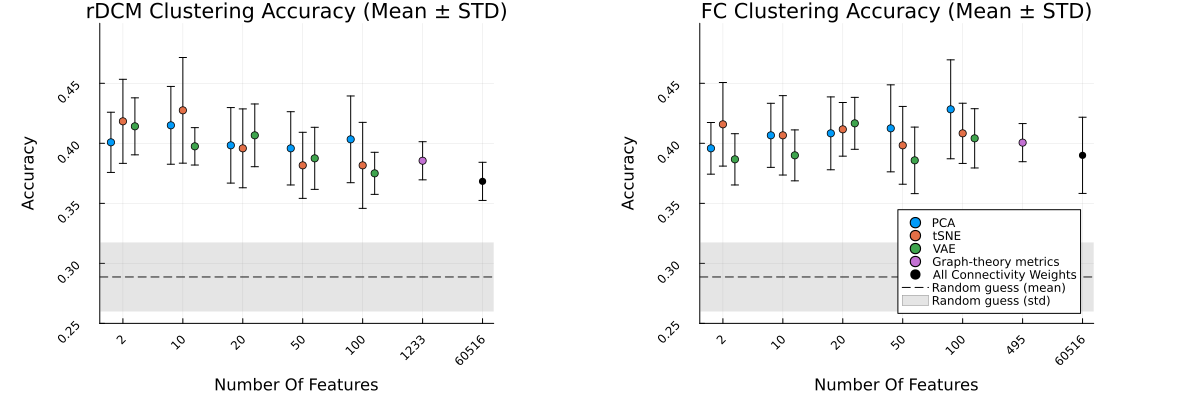

In [14]:
using Plots

# Extract the noLatent values
rdcm_noLatent = results_noLatent[(results_noLatent.Data .== "RDCM") .& (results_noLatent.Clustering .== "kmeans"), :]
fc_noLatent = results_noLatent[(results_noLatent.Data .== "FC") .& (results_noLatent.Clustering .== "kmeans"), :]


rdcm_graph = results_Graph[(results_Graph.Data .== "RDCM") .& (results_Graph.Clustering .== "kmeans"), :]
fc_graph = results_Graph[(results_Graph.Data .== "FC") .& (results_Graph.Clustering .== "kmeans"), :]



dims_list = [2, 10, 20, 50, 100]
all_x_positions = [dims_list; 150;155]  # Add 150 for NoLatent

# Create positions dictionary with NoLatent at position 6 (after the 5 dimensions)
x_positions = Dict(d => i for (i, d) in enumerate(all_x_positions))

# Offset by method only
method_offset = Dict("NoLatent" => 0.0, "PCA" => -0.2, "tSNE" => 0.0, "VAE" => 0.2)

# Create a plot with 2 subplots
plot(layout = (1, 2), size = (1200, 400), legend = :outerright, left_margin = 10mm, right_margin = 25mm, bottom_margin = 10mm)

# First subplot: RDCM
for g in grouped_dimExp
    if g.Data[1] != "RDCM"
        continue
    end
    if g.Clustering[1] != "kmeans"
        continue
    end

    method = g.Method[1]
    label = method

    x_base = [x_positions[d] for d in g.Dims]
    x_vals = [x + get(method_offset, method, 0.0) for x in x_base]

    plot!(
        subplot = 1,
        x_vals, g.MeanAcc;
        yerror = g.StdAcc,
        label = "",
        seriestype = :scatter,
        marker = :circle,
    )
end

plot!(
    subplot = 1,
    [x_positions[150] + method_offset["NoLatent"]], [rdcm_graph.MeanAcc[1]];
    yerror = [rdcm_noLatent.StdAcc[1]],
    label = "",
    seriestype = :scatter,
    marker = :circle,
)
plot!(
    subplot = 1,
    [x_positions[155] + method_offset["NoLatent"]], [rdcm_noLatent.MeanAcc[1]];
    yerror = [rdcm_noLatent.StdAcc[1]],
    label = "",
    seriestype = :scatter,
    marker = :circle,
    color = :black, 
    margin = 0mm
)


# Chance-level horizontal line for RDCM
hline!([mean_acc_random]; subplot = 1, linestyle=:dash, color=:black, label= "")

# Shaded std band
hspan!([mean_acc_random - std_acc_random, mean_acc_random + std_acc_random]; 
       subplot = 1, alpha=0.2, color=:gray, label="")

# Axis labels and ticks for RDCM - x labels at bottom
xticks!(subplot=1, (1:length(all_x_positions)), 
       [string.(dims_list);"1233" ;"60516"], 
       rotation=45)
xlabel!(subplot=1, "Number Of Features")
ylabel!(subplot=1, "Accuracy")
title!(subplot=1, "rDCM Clustering Accuracy (Mean ± STD)")
plot!(legend = false)

# Second subplot: Functional Connectivity
for g in grouped_dimExp
    if g.Data[1] != "FC"
        continue
    end
    if g.Clustering[1] != "kmeans"
        continue
    end

    method = g.Method[1]
    label = method

    x_base = [x_positions[d] for d in g.Dims]
    x_vals = [x + get(method_offset, method, 0.0) for x in x_base]

    plot!(
        subplot = 2,
        x_vals, g.MeanAcc;
        yerror = g.StdAcc,
        label = label,
        seriestype = :scatter,
        marker = :circle,
    )
end

# Add the noLatent point for FC at x=150
plot!(
    subplot = 2,
    [x_positions[150] + method_offset["NoLatent"]], [fc_graph.MeanAcc[1]];
    yerror = [rdcm_noLatent.StdAcc[1]],
    label = "Graph-theory metrics",
    seriestype = :scatter,
    marker = :circle,
)
plot!(
    subplot = 2,
    [x_positions[155] + method_offset["NoLatent"]], [fc_noLatent.MeanAcc[1]];
    yerror = [fc_noLatent.StdAcc[1]],
    label = "All Connectivity Weights",
    seriestype = :scatter,
    marker = :circle,
    color = :black
)


ylims!(0.25, 0.5; subplot=1)
ylims!(0.25, 0.5; subplot=2)

# Chance-level horizontal line for FC
hline!([mean_acc_random]; subplot = 2, linestyle=:dash, color=:black, 
       label= "Random guess (mean)")

# Shaded std band
hspan!([mean_acc_random - std_acc_random, mean_acc_random + std_acc_random]; 
       subplot = 2, alpha=0.2, color=:gray, label="Random guess (std)")

# Axis labels and ticks for FC - x labels at bottom
xticks!(subplot=2, (1:length(all_x_positions)), 
       [string.(dims_list); "495" ;"60516"], 
       rotation=45)
xlabel!(subplot=2, "Number Of Features")
ylabel!(subplot=2, "Accuracy")
title!(subplot=2, "FC Clustering Accuracy (Mean ± STD)")

# Adjust legend to show only once (right side)
plot!(legend = :bottomright)


Estimated Connectivity Heatmap 

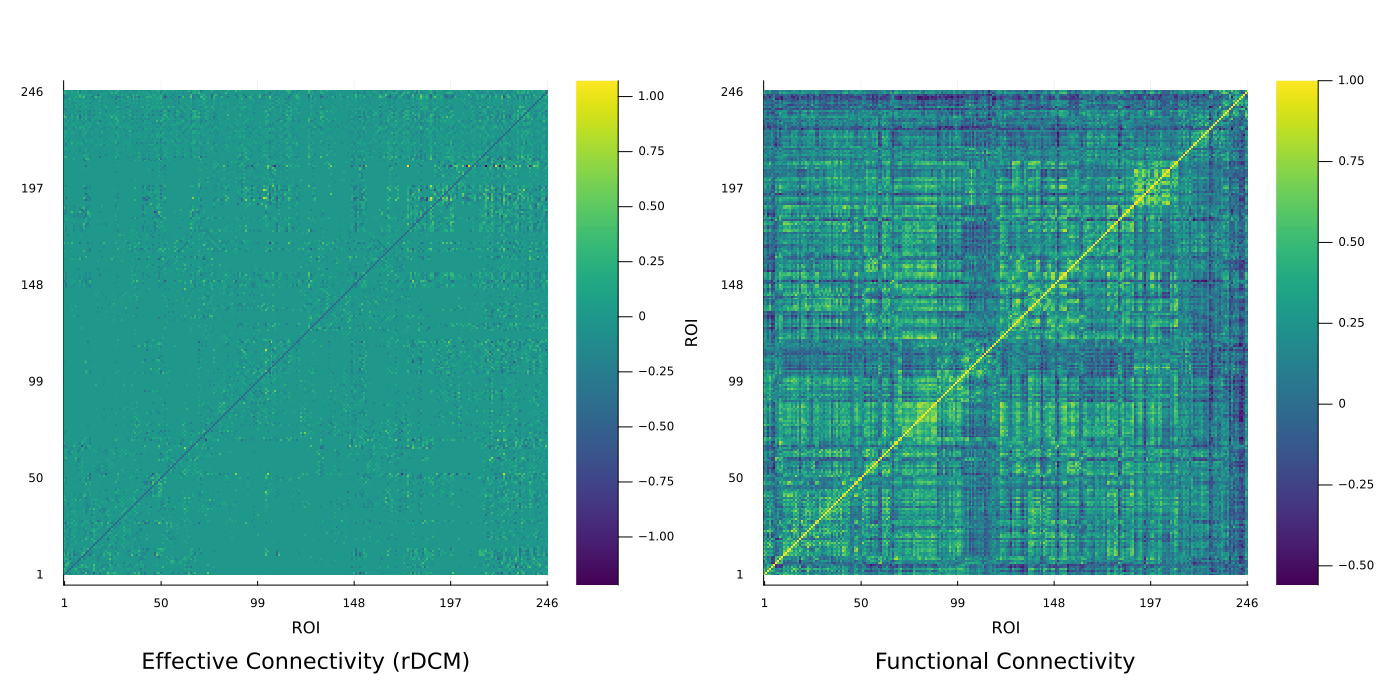

"g:\\Lyubov\\TNM_project\\connectivity.pdf"

In [ ]:
using Plots

# Get data dimensions
n = size(connectivity_data["0006315"]["rdcm"], 1)

# Set up tick marks
tick_step = 49
tick_positions = 1:tick_step:n
tick_labels = string.(tick_positions)

# Create a new plot with 1 row and 2 columns
p = plot(layout=(1,2), size=(1400,700), top_margin=0mm)

# First subplot - Effective Connectivity
heatmap!(
    p[1],
    connectivity_data["0006315"]["rdcm"],
    aspect_ratio=1,
    xlabel="ROI",
    ylabel="ROI",
    colorbar=true,
    color=:viridis,
    xticks=(tick_positions, tick_labels),
    yticks=(tick_positions, tick_labels), 
)
annotate!(p[1], (0.5, -0.15), text("Effective Connectivity (rDCM)", 15, :center))

# Second subplot - Functional Connectivity
heatmap!(
    p[2],
    connectivity_data["0006315"]["fc_mat"],
    aspect_ratio=1,
    xlabel="ROI",
    ylabel="ROI",
    colorbar=true,
    color=:viridis,
    xticks=(tick_positions, tick_labels),
    yticks=(tick_positions, tick_labels)
)
annotate!(p[2], (0.5, -0.15), text("Functional Connectivity", 15, :center))

# Display the plot
display(p)
